# `mle-scheduler`: Lightweight Cluster/Cloud Job Management 🚀
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: November 2021][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mle-infrastructure/mle-scheduler/blob/main/examples/getting_started.ipynb)

"How does one specify the amount of required CPU cores and GPU type again?" I really dislike having to write cluster job submission files. It is tedious, I always forget something and copying old templates feels cumbersome. The classic boilerplate code problem. What if instead there was a tool that would completely get rid of this manual work? **A tool that schedules jobs on different cluster/cloud resources** with minimal and intuitive job/resource description requirements?  The `mle-scheduler` package provides such a service for [Slurm](https://slurm.schedmd.com/), [Open Grid Engine](http://gridscheduler.sourceforge.net/documentation.html) cluster schedulers & [Google Cloud Platform VMs](https://cloud.google.com/gcp/). But you can also use the scheduling utilities to launch multiple training runs on a local machine or a set of SSH servers. This includes running the same configuration on multiple random seeds and/or training multiple configuration runs simultaneously. It comes with two core functional pillars:

- **`MLEJob`**: Launches and monitors a single job on a resource (Slurm, Open Grid Engine, GCP, SSH, etc.).
- **`MLEQueue`**: Launches and monitors a queue of jobs with different training configurations and/or random seeds.

In the remainder of this walkthrough we will first introduce the general logic locally and afterwards go through how to launch and monitor jobs on the different clusters, SSH servers and GCP VMs. Importantly, the `mle-scheduler` is part of the broader [`mle-infrastructure`](https://github.com/mle-infrastructure) and comes with a set of handy built-in synergies. We will wrap-up by highlighting some of these.

<a href="https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/mle_scheduler_structure.png?raw=true"><img src="https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/mle_scheduler_structure.png?raw=true" width="850" align="center" /></a>

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import mle_scheduler
except:
    !pip install -q mle-scheduler mle-logging
!pip install -q -U PyYAML
import os, logging

Let's start by setting up a simple training script. In the code snippet below we "pseudo"-train a network for 10 epochs and log the training run statistics using [`mle-logging`](https://github.com/mle-infrastructure/mle-logging). I use it on a daily basis and throughout my experiments - but you can plug-in whatever logging setup you prefer. We store the code in a `train.py` file. Our execution script takes three command line arguments that are being parsed at the start-up: `experiment_dir` (the main log directory), `config_fname` (the configuration file to be loaded), `seed_id` (the random number seed for reproduction). The black-box training loop then runs for some epochs and continuously logs some data to our logger.

```python
from mle_logging import MLELogger
from mle_logging.utils import load_yaml_config


def main(experiment_dir: str, config_fname: str, seed_id: int):
    """Example training 'loop' using MLE-Logging."""
    # Load experiment configuration & setup logging to experiment_dir
    train_config = load_yaml_config(config_fname)
    log = MLELogger(
        experiment_dir=experiment_dir,
        config_fname=config_fname,
        seed_id=seed_id,
        time_to_track=["num_epochs"],
        what_to_track=["train_loss", "test_loss"],
    )
    # 'Run' the pseudo training loop and feed the logger
    for epoch in range(1, 11):
        train_loss, test_loss = train_your_net(epoch, seed_id, **train_config)
        log.update(
            {"num_epochs": epoch},
            {"train_loss": train_loss, "test_loss": test_loss},
            save=True,
        )
        

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Let's train a network.")
    parser.add_argument("-exp_dir", "--experiment_dir", type=str)
    parser.add_argument("-config", "--config_fname", type=str)
    parser.add_argument("-seed", "--seed_id", type=int, default=1)
    args = vars(parser.parse_args())
    main(args["experiment_dir"], args["config_fname"], args["seed_id"])
```

In [ ]:
# Check if code is run in Colab: If so -- download configs from repo
try:
    import google.colab
    IN_COLAB = True
    !wget -q https://raw.githubusercontent.com/mle-infrastructure/mle-scheduler/main/examples/train.py
    !wget -q https://raw.githubusercontent.com/mle-infrastructure/mle-scheduler/main/examples/base_config_1.yaml
    !wget -q https://raw.githubusercontent.com/mle-infrastructure/mle-scheduler/main/examples/base_config_2.yaml
    !wget -q https://raw.githubusercontent.com/mle-infrastructure/mle-scheduler/main/examples/requirements.txt
except:
    IN_COLAB = False

# Single Job Management with `MLEJob` 🚀

So now that we have defined our training script how shall we launch it? The most natural thing to do would be to execute the python script with command line input via:

```
python train.py -config base_config_1.yaml -exp_dir logs_single -seed_id 1
```

The same can be achieved programmatically using an instance of `MLEJob`. In the cell below you can see how to spawn a process which executes the same python command and continuously monitors it until the job is completed:

In [2]:
from mle_scheduler import MLEJob

job = MLEJob(resource_to_run="local",
             job_filename="train.py",
             config_filename="base_config_1.yaml",
             experiment_dir="logs_single",
             seed_id=1,
             logger_level=logging.INFO)

_ = job.run()

`config_filename`, `experiment_dir` and `seed_id` are three command line arguments, which I found myself to be using fairly often. But they are not at all necessary for job execution via the `MLEJob`. Indeed, you can provide a `extra_cmd_line_input` dictionary at job instance creation, which specifies key, value pairs for `-<key> <value>`-style arguments. E.g.

```python
MLEJob(
    resource_to_run="local",
    job_filename="train.py",
    extra_cmd_line_input={"optim": "Adam", "lrate": 0.1},
)
```

will launch `python train.py -optim Adam -lrate -0.1`. By default the job will be executed from your current local shell instance (so with your currently activated environment settings). You can also provide a set of `job_arguments` to execute the job in a previously created virtual environment of your choice:

```python
MLEJob(
    resource_to_run="local",
    job_filename="train.py",
    job_arguments={
        "use_conda_venv": True,
        "use_venv_venv": False,
        "env_name": "mle-toolbox",
    },
    config_filename="base_config_1.yaml",
    experiment_dir="logs_single",
    seed_id=1,
)
```

This will activate a conda virtual environment named `mle-toolbox` before executing the Python script. Finally, instead of automatically monitoring the job until completion, you can also manually monitor the status of a previously scheduled job by combining `job.schedule` and `job.monitor`:

In [3]:
job_id = job.schedule()
while True:
    status = job.monitor(job_id)
    if status == 0:
        break

The `MLEJob` class provides a simple primitive for managing a single job. But most of the time we are interested in collecting results simultaneously for many different jobs.

# Job Queue Management with `MLEQueue` 🚀,...,🚀

We can launch multiple runs for different configurations and random seeds in a queue, that will execute them simultaneously using the `MLEQueue`. The queue wraps around `MLEJob` and will by default run and monitor the jobs all at once. The following code for example will execute 4 runs for two configurations (`base_config_1.yaml` and `base_config_2.yaml`) with two different random seeds (`0` and `1`) alà:

```
python train.py -config base_config_1.yaml -seed 0 -exp_dir logs_queue/<date>_base_config_1
python train.py -config base_config_1.yaml -seed 1 -exp_dir logs_queue/<date>_base_config_1
python train.py -config base_config_2.yaml -seed 0 -exp_dir logs_queue/<date>_base_config_2
python train.py -config base_config_2.yaml -seed 1 -exp_dir logs_queue/<date>_base_config_2
```

In [4]:
from mle_scheduler import MLEQueue

queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue",
                 logger_level=logging.INFO)
queue.run()

Output()

By default all jobs will be launched/queued in parallel. But you can also control how many jobs to schedule at a given point in time. E.g. if you don't want more than 10 jobs to be running/queued simultaneously simply add the `max_running_jobs=<num_jobs>` option to the `MLEQueue`. In this case a new job will be launched, whenever a previously queued job terminates and there still remain unscheduled ones left in the queue. If you want to run batches of jobs as for example in Batch Bayesian Optimization or synchronous Population-Based Training you will have to instantiate multiple queues sequentially and wait until the previous one completes.

Above we have explicitly provided the random seeds we would like to run our experiment on. Alternatively, if you would like to randomly generate these seeds, you can also simply specify the number of desired seeds via the `num_seeds` option. And again, you can use `job_arguments` to specify a virtual environment or different command line arguments via `extra_cmd_line_input`.

# Launching Slurm/GridEngine Cluster-Based Jobs 🐒/🐘

All the previous code runs perfectly fine on a single local machine (e.g. the Colab/notebook server you are executing these cells on). But the true power of the `mle-scheduler` lies in its capabilities to run jobs on multiple remote compute nodes such as high-performance clusters (HPC). At the point of writing the `mle-scheduler` implements job launch/monitor utilities for both [Slurm](https://slurm.schedmd.com/) and [Open Grid Engine](http://gridscheduler.sourceforge.net/documentation.html) schedulers. So how does one specify the resources that one wants to request when scheduling a job? This happens via the `job_arguments` input dictionary. For both cluster schedulers, you have the following resource options: 

|*All Schedulers*| Type | Optional | Description | 
|----|:----: | :----: | ----|
|`num_logical_cores` | `int` | ❌ | Number of logical cores requested per job
|`num_gpus` | `int` | ✔️ | Number of GPUs requested per job
|`gpu_type` | `str` | ✔️ | Type of GPU requested per job
|`memory_per_job` | `int` | ✔️ | Memory in MB requested per job
|`time_per_job` | `str` | ✔️ | Max. job run time (`dd:hh:mm`) before termination
|`env_name` | `str` | ✔️ | Virtual environment name to activate at job start-up
|`use_conda_venv` | `bool` | ✔️ | Whether to use a `virtualenv`-based environment
|`use_venv_venv` | `bool` | ✔️ | Whether to use an Anaconda-based environment
|`job_name` | `str` | ✔️ | Job name of scheduled job shown in (`squeue`/`qstat`)

For Slurm schedulers you have the following additional arguments:

|*Only Slurm*| Type | Optional | Description | 
|----|:----: | :----: | ----|
|`partition` | `str` | ❌ | Partition to schedule job on
|`modules_to_load` | `Union[List[str], str]` | ✔️ | Modules to load at job start-up

And for Open Grid Engine schedulers:

|*Only Grid Engine* | Type | Optional | Description | 
|----|:----: | :----: | ----|
|`queue` | `str` | ❌ | Queue to schedule job on
|`gpu_prefix` | `str` | ✔️ | Prefix to request GPU nodes (`#$ -l {gpu_prefix}="{num_gpus}"`)
|`exclude_nodes` | `List[str]` | ✔️ | List of node addresses to exclude from being scheduled on

Importantly, when launching a `MLEJob`/`MLEQueue` we assume that you are currently on the headnode of your cluster which uses a standard shared file system. They will then generate job submission files based on a simple templating approach. These will then be executed via `sbatch` or `qsub`. The status of the individual jobs is tracked by continuously checking up on them using `squeue` and `qstat`. This is fairly lightweight and can easily be run on the headnode. [In a future release I plan on adding the option to launch cluster jobs from your local machine and to add Singularity/Docker containerization support!] Otherwise everything else remains the same as before:

In [ ]:
# Each job requests 5 CPU cores & 1 V100S GPU w. CUDA 10.0 loaded
job_args = {
    "partition": "<SLURM_PARTITION>",  # Partition to schedule jobs on
    "env_name": "mle-toolbox",  # Env to activate at job start-up
    "use_conda_venv": True,  # Whether to use anaconda venv
    "num_logical_cores": 5,  # Number of requested CPU cores per job
    "num_gpus": 1,  # Number of requested GPUs per job
    "gpu_type": "V100S",  # GPU model requested for each job
    "modules_to_load": "nvidia/cuda/10.0"  # Modules to load at start-up
}


queue = MLEQueue(
    resource_to_run="slurm-cluster",
    job_filename="train.py",
    job_arguments=job_args,
    config_filenames=["base_config_1.yaml", "base_config_2.yaml"],
    experiment_dir="logs_queue_slurm",
    random_seeds=[0, 1]
)
queue.run()

# Launching SSH Server-Based Jobs 🦊

Not every academic lab may have access to an institution-wide HPC. Instead you may be working with a set of servers, which you can access via SSH. The `mle-scheduler` also allows you to launch jobs in such situations. In order to do so, you will first need to have setup passwordless SSH access to your. This can for example be done by following [these](https://linuxize.com/post/how-to-setup-passwordless-ssh-login/) instructions and will create a private key on your local machine (e.g. a file called `~/.ssh/id_rsa`). You will have to provide this key path as well as your user name, server address, SSH port and the remote code directory in the `ssh_settings` which will be passed to the `MLEJob` & `MLEQueue` instances. This will allow us to establish a SSH connection using the [`paramiko`](https://github.com/paramiko/paramiko) client.

For all SSH server-based jobs you have to then provide the following `ssh_settings` input to `MLEJob` and `MLEQueue`:

|| Type | Optional | Description | 
|----|:----: | :----: | ----|
|`user_name` | `str` | ❌ | SSH server user name
|`pkey_path` | `str` | ❌ | Private key path (e.g. ~/.ssh/id_rsa)
|`main_server` | `str` | ❌ | SSH Server address
|`jump_server` | `str` | ❌ | Jump host address
|`ssh_port` | `int` | ❌ | SSH port (e.g. 22)
|`remote_dir` | `str` | ❌ | Dir to sync code to on server
|`start_up_copy_dir` | `str` | ✔️/❌ | Whether to copy code to server
|`clean_up_remote_dir` | `str` | ✔️/❌ | Whether to delete remote_dir on exit

In order to launch a job from your local machine on the remote server you will most likely first need to copy the code directory to the server. This can either be done manually using `scp` or using the `send_code_ssh` function. By default this will send the current working directory to `ssh_settings["remote_dir"]`:

In [5]:
from mle_scheduler.ssh import send_dir_ssh, copy_dir_ssh, delete_dir_ssh

ssh_settings = {
    "user_name": os.environ["SSH_USER_NAME"],  # SSH server user name
    "pkey_path": os.environ["PKEY_PATH"],  # Private key path (e.g. ~/.ssh/id_rsa)
    "main_server": os.environ["SSH_SERVER"],  # SSH Server address
    "jump_server": '',  # Jump host address
    "ssh_port": 22,  # SSH port
    "remote_dir": "mle-code-dir",  # Dir to sync code to on server
}

# scp the current working directory to a mle-code-dir remote
send_dir_ssh(ssh_settings)

2021-11-11 19:23:32,291| ERROR   | Could not establish connection from local ('127.0.0.1', 49191) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


Afterwards, we are ready to run the job on the SSH server by `ssh_settings` to our `MLEJob` instance. Once the job is completed the results can be copied back to your local machine using `copy_results_ssh` and the directory path storing the results. Finally, you can use `clean_up_ssh` to delete the previously copied code directory:

In [6]:
job = MLEJob(resource_to_run="ssh-node",
             job_filename="train.py",
             config_filename="base_config_1.yaml",
             experiment_dir="logs_ssh_single",
             job_arguments={"env_name": "mle-toolbox",
                            "use_conda_venv": True},
             ssh_settings=ssh_settings,
             logger_level=logging.INFO)

job.run()

# Copy over the results from the SSH server
copy_dir_ssh(ssh_settings, remote_dir="mle-code-dir/logs_ssh_single")

# Delete the code directory on the SSH server
delete_dir_ssh(ssh_settings)

2021-11-11 19:23:49,742| ERROR   | Could not establish connection from local ('127.0.0.1', 49208) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


If you would like to run a queue of jobs, you don't want to copy the same code directory over to the server each time. Instead, the `MLEQueue` will copy the directory (if desired) once at start-up and will delete it again once all jobs have terminated. Furthermore, it will automatically copy the results in to your local execution directory. Note that the error log messages don't have to bother us. They simply come from the ssh client needing a couple of attempts to establish a connection.

In [7]:
ssh_settings["start_up_copy_dir"] = True  # Whether to copy code to server
ssh_settings["clean_up_remote_dir"] = True  # Whether to delete remote_dir on exit

queue = MLEQueue(resource_to_run="ssh-node",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_ssh_queue",
                 job_arguments={"env_name": "mle-toolbox",
                                "use_conda_venv": True},
                 ssh_settings=ssh_settings,
                 logger_level=logging.INFO)

queue.run()

2021-11-11 19:24:24,019| ERROR   | Could not establish connection from local ('127.0.0.1', 49221) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 
2021-11-11 19:24:39,364| ERROR   | Could not establish connection from local ('127.0.0.1', 49227) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


Output()

2021-11-11 19:25:14,439| ERROR   | Could not establish connection from local ('127.0.0.1', 49246) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


2021-11-11 19:25:19,431| ERROR   | Could not establish connection from local ('127.0.0.1', 49249) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


# Launching GCP VM-Based Jobs 🦄

Finally, let's talk about how to create GCP VM-based jobs using the `mle-scheduler`. This will require you to have already setup Google Cloud SDK and to have created a GCP project and a GCS bucket. Furthermore you will have to provide you `.json` authentication key path. If you don't have one yet, have a look [here](https://cloud.google.com/docs/authentication/getting-started). Alternatively, just make sure that the environment variable `GOOGLE_APPLICATION_CREDENTIALS` is set to the right path. You have to provide the following `cloud_settings`:

|| Type | Optional | Description | 
|----|:----: | :----: | ----|
|`project_name` | `str` | ❌ | Name of your GCP project
|`bucket_name` | `str` | ❌ | Name of your GCS bucket
|`remote_dir` | `str` | ❌ | Name of code dir in bucket
|`start_up_copy_dir` | `str` | ✔️/❌ | Whether to copy code to bucket
|`clean_up_remote_dir` | `str` | ✔️/❌ | Whether to delete remote_dir on exit

As for the SSH server jobs we start by copying the code repository in a GCS bucket. In order to know where to sync these files to, you will need to provide the `project_name`, `bucket_name` and the name of the code directory in the bucket. Note that later on all generated results logs will also be stored in this GCS `remote_dir`:

In [8]:
# Import utility to copy local code directory to GCS bucket
from mle_scheduler.cloud.gcp import send_dir_gcp, copy_dir_gcp, delete_dir_gcp

cloud_settings = {
    "project_name": "mle-toolbox",  # Name of your GCP project
    "bucket_name": "mle-protocol", # Name of your GCS bucket
    "remote_dir": "mle-code-dir",  # Name of code dir in bucket
}

# Send config file to remote machine - independent of code base!
send_dir_gcp(cloud_settings)

At VM startup each of the individual GCP VM instances will `gsync` copy the code and install a `requirements.txt` file in a fresh Python virtual environment. By default the created VMs are [`n1-high-cpu` custom VMs](https://cloud.google.com/compute/docs/general-purpose-machines#n1-high-cpu) since they allow for GPU attachment. The `N1` VMs allow for 1, 2, 4, 8, 16, 32 & 48 logical cores (x2 with hyperthreading) and up to 624 GB of memory. Right now the GCP `MLEJob` will also by default setup a `c1-deeplearning-tf-2-4-cu110-v20210414-debian-10` image from the `ml-images` family, which comes with CUDA 11.0 drivers ready to go. [In the future I plan on adding more flexibility to specify resource requests through the `mle-scheduler` and to support TPU VMs.]

In [9]:
job_args = {
    "num_gpus": 0,  # Number of requested GPUs per job
    "gpu_type": None,  # GPU requested e.g. "nvidia-tesla-v100"
    "num_logical_cores": 1,  # Number of requested CPU cores per job
}

job = MLEJob(
    resource_to_run="gcp-cloud",
    job_filename="train.py",
    config_filename="base_config_1.yaml",
    experiment_dir="logs_gcp_single",
    job_arguments=job_args,
    cloud_settings=cloud_settings,
    logger_level=logging.INFO
)

job.run()

# Copy over the results from the SSH server
copy_dir_gcp(cloud_settings, remote_dir="mle-code-dir/logs_gcp_single")

# Delete the code directory on the SSH server
delete_dir_gcp(cloud_settings)

The `MLEJob` instance will create a GCP VM using the SDK syntax and automatically execute a command which looks like this:

```
gcloud compute instances create <job_name> --preemptible --zone=us-west1-a \
    --custom-cpu=2 \
    --custom-memory=6144MB \
    --custom-vm-type=n1 \
    --image=c1-deeplearning-tf-2-4-cu110-v20210414-debian-10 \
    --image-project=ml-images \
    --metadata-from-file=startup-script=<job_name>-<datetime>-startup.sh \
    --scopes=cloud-platform,storage-full \
    --boot-disk-size=128GB \
    --boot-disk-type=pd-standard \
    --no-user-output-enabled \
    --verbosity error
```

Again, for a single job you can copy over the results and delete the code stored in GCS bucket using `copy_dir_gcp` and `delete_dir_gcp`. The `MLEQueue` works as before for the SSH server setting and will take care of copying and cleaning up the code directory once all jobs have terminated successfully. Note that spawning many jobs simultaneously may be prohibited by your personal resource quota.

In [10]:
cloud_settings["start_up_copy_dir"] = True
cloud_settings["clean_up_remote_dir"] = True

queue = MLEQueue(
    resource_to_run="gcp-cloud",
    job_filename="train.py",
    config_filenames=["base_config_1.yaml", "base_config_2.yaml"],
    random_seeds=[0, 1],
    experiment_dir="logs_gcp_queue",
    job_arguments=job_args,
    cloud_settings=cloud_settings,
    logger_level=logging.INFO
)
queue.run()

Output()

# Slack Notifications for Real-Time Queue Status 📮

You can also get a Slack Bot notification of the current status of the queue. This is powered by the [`slack-clusterbot`](https://github.com/sprekelerlab/slack-clusterbot) package (simply `pip install` it) and you can follow these instructions to setup a bot for your favorite workspace [here](https://github.com/sprekelerlab/slack-clusterbot/wiki/Installation). After you have obtained your authentication token it is as simple as providing the token and your user name as inputs. Below you can find the slack chat output:

In [11]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue",
                 job_arguments={"env_name": "mle-toolbox"},
                 slack_user_name=os.environ["SLACK_USER_NAME"],
                 slack_auth_token=os.environ["SLACK_AUTH_TOKEN"])
queue.run()

Output()

<a href="https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/slackbot_output.png?raw=true"><img src="https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/slackbot_output.png?raw=true" width="600" align="center" /></a>

# Automatic Log Merging & Plotting with `mle-logging` 📖

The [`mle-scheduler`](https://github.com/mle-infrastructure/mle-scheduler) is part of the broader [`mle-infrastructure`](https://github.com/mle-infrastructure). It therefore has some synergetic features with other packages such as the already mentioned [`mle-logging`](https://github.com/mle-infrastructure/mle-logging) or [`mle-hyperopt`](https://github.com/mle-infrastructure/mle-hyperopt). One of such features is automatic log aggregation after successful completion of all random seeds in `MLEQueue`. All you have to do is supply the option `automerge_seeds`: 

In [12]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_merge",
                 automerge_seeds=True,
                 logger_level=logging.INFO)
queue.run()

Output()

You can then easily load and visualize the results as follows:

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'train_loss, test_loss'}, xlabel='num_epochs', ylabel='train_loss, test_loss'>)

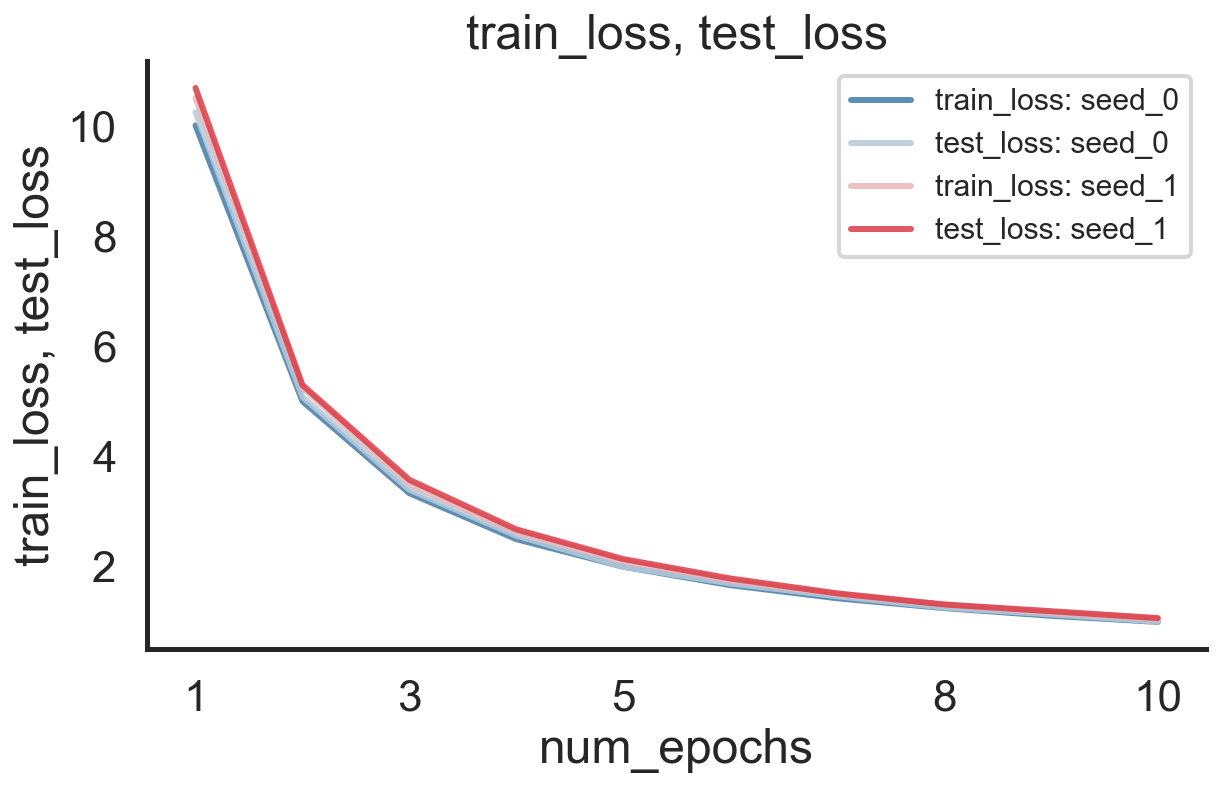

In [13]:
from mle_logging import load_log
import datetime
date = datetime.datetime.today().strftime("%Y-%m-%d")[2:]
log = load_log(f"logs_merge/{date}_base_config_1")
log.plot(["train_loss", "test_loss"])

# Search Jobs with `mle-hyperopt` Configurations 🚂

Finally, `mle-scheduler` integrates smoothly with the hyperparameter search tool `mle-hyperopt`. After defining a search strategy, `mle-hyperopt` allows us to get a set of candidate hyperparameters and to export them as configuration files in one go:

In [2]:
try:
    import mle_hyperopt
except:
    !pip install -q mle-hyperopt
    import mle_hyperopt

from mle_hyperopt import RandomSearch

# Instantiate random search class
strategy = RandomSearch(real={"lrate": {"begin": 0.1,
                                        "end": 0.5,
                                        "prior": "log-uniform"}},
                        integer={"batch_size": {"begin": 1,
                                                "end": 5,
                                                "prior": "uniform"}},
                        categorical={"arch": ["mlp", "cnn"]})

# Simple ask - eval - tell API
configs, config_fnames = strategy.ask(2, store=True)
print(f"MLE-Hyperopt Stored Configurations: {config_fnames}")

MLE-Hyperopt Stored Configurations: ['eval_0.yaml', 'eval_1.yaml']


Next we simply forward the configuration filenames to the `MLEQueue` and voilà we have a batch of search configurations running:

In [3]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=config_fnames,
                 experiment_dir="logs_search")
queue.run()

Output()

Give it a try and let me know what you think! If you find a bug or are missing your favourite feature, feel free to contact me [@RobertTLange](https://twitter.com/RobertTLange) or create an issue!